# Задание

Данные содержат информацию о выданных кредитах, требуется предсказать вероятность успешного возврата кредита.

Тренировочная выборка содержится в файле **train.csv**, тестовая -- **test.csv**.

Информация о значениях признаков содержится в файле **feature_descr.xlsx**.

Целевой признак -- **loan_status** (бинарный). 1 означает что кредит успешно вернули.

В рамках тестового задания вам предлагается:

* Обучить модель на предоставленных данных, найти качество полученной модели.
* Записать предсказания (вероятности) для тестового набора в файл **results.csv**
* Продемонстрировать результаты анализа в графическом виде (ROC-curve)


Тщательный выбор фич и подбор гиперпараметров можно не проводить.

# Решение

In [1]:
import pandas as pd

In [2]:
import sys
print "Python version: {}".format(sys.version)
print "Pandas version: {}".format(pd.__version__)

Python version: 2.7.13 |Anaconda 4.3.1 (64-bit)| (default, Dec 19 2016, 13:29:36) [MSC v.1500 64 bit (AMD64)]
Pandas version: 0.19.2


Тут стоит заметить что использовался Python 2.7

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Читаем данные из train.csv, используя record_id как индекс:

In [4]:
train = pd.read_csv('train.csv', index_col='record_id')
train.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
record_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
453246940,15000.0,36 months,11.99,498.15,B,B3,Quality Assurance Specialist,4 years,MORTGAGE,70000.0,Verified,Oct-2013,1,n,debt_consolidation,156xx,PA,13.85,0.0,Dec-1991,1.0,NaN,17.0,3.0,12540.0,61.2,32.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,295215.0,20500.0
453313687,3725.0,36 months,6.03,113.38,A,A1,NaN,n/a,MORTGAGE,52260.0,Source Verified,Oct-2012,1,n,credit_card,339xx,FL,19.43,0.0,Oct-2000,0.0,NaN,7.0,0.0,3730.0,26.3,9.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,25130.0,14200.0
453283543,16000.0,36 months,11.14,524.89,B,B2,KIPP NYC,3 years,RENT,67500.0,Source Verified,Apr-2013,1,n,debt_consolidation,104xx,NY,14.77,0.0,Jul-2001,0.0,NaN,9.0,0.0,11769.0,60.5,22.0,f,0.0,1.0,INDIVIDUAL,0.0,193.0,41737.0,19448.0
453447199,4200.0,36 months,13.33,142.19,C,C3,Receptionist,< 1 year,MORTGAGE,21600.0,Not Verified,Mar-2015,0,n,major_purchase,982xx,WA,39.00,0.0,May-2003,0.0,47.0,9.0,0.0,6797.0,46.9,19.0,w,0.0,1.0,INDIVIDUAL,0.0,165.0,28187.0,14500.0
453350283,6500.0,36 months,12.69,218.05,B,B5,Medtox Laboratories,10+ years,RENT,41000.0,Not Verified,Jan-2012,1,n,credit_card,551xx,MN,18.35,0.0,Sep-1990,0.0,NaN,8.0,0.0,14674.0,82.4,12.0,f,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN


In [5]:
train.shape

(200189, 35)

Смотрим, какие типы данных в столбцах:

In [6]:
train.dtypes

loan_amnt                     float64
term                           object
int_rate                      float64
installment                   float64
grade                          object
sub_grade                      object
emp_title                      object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                        object
loan_status                     int64
pymnt_plan                     object
purpose                        object
zip_code                       object
addr_state                     object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line               object
inq_last_6mths                float64
mths_since_last_delinq        float64
open_acc                      float64
pub_rec                       float64
revol_bal                     float64
revol_util                    float64
total_acc   

Исследуем поля на наличие пропусков:

In [7]:
train.isnull().sum()

loan_amnt                          0
term                               0
int_rate                           0
installment                        0
grade                              0
sub_grade                          0
emp_title                      11124
emp_length                         0
home_ownership                     0
annual_inc                         0
verification_status                0
issue_d                            0
loan_status                        0
pymnt_plan                         0
purpose                            0
zip_code                           0
addr_state                         0
dti                                0
delinq_2yrs                        0
earliest_cr_line                   0
inq_last_6mths                     0
mths_since_last_delinq        110568
open_acc                           0
pub_rec                            0
revol_bal                          0
revol_util                       154
total_acc                          0
i

Следующие столбцы имеют пропуски:

### emp_title - The job title supplied by the Borrower when applying for the loan
\- Должность заемщика, вещь вроде полезная, но нестандартизирована, слишком много различных значений; отбрасываем этот столбец, но добавим флаг, указана ли была должность вообще:

In [8]:
train['is_title_known'] = train['emp_title'].map(lambda x: 0 if x == 'n/a' else 1)
train.drop('emp_title', axis=1, inplace=True)

### mths_since_last_delinq - The number of months since the borrower's last delinquency
\- кол-во месяцев с момента последнего неосуществления платежа в установленный срок. Заменить пропуски на 0 будет неправильно, заменим их на max в этом столбце и добавим столбец is_delinq_occurs с флагом, был ли факт неплатежа ранее

In [9]:
import numpy as np
import math
train['is_delinq_occurs'] = train['mths_since_last_delinq'].map(lambda x: 0 if math.isnan(x) else 1)

max_mths_since_last_delinq = np.nanmax(train.mths_since_last_delinq.values)
train['mths_since_last_delinq'].fillna(max_mths_since_last_delinq, inplace=True)

### revol_util - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit

### collections_12_mths_ex_med - Number of collections in 12 months excluding medical collections

### tot_coll_amt - Total collection amounts ever owed

### tot_cur_bal - Total current balance of all accounts

### total_rev_hi_lim - Total revolving high credit/credit limit
Мне неизвестны тонкости этого бизнес-домена, поэтому заменяем пропуски на нули с помощью функции fillna():

In [10]:
train.fillna(0, inplace=True)
train.isnull().sum()

loan_amnt                     0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
mths_since_last_delinq        0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
collections_12_mths_ex_med    0
policy_code                   0
application_type              0
acc_now_delinq                0
tot_coll

\- Пропусков теперь нет

Разбиваем данные на X и Y:

In [11]:
def extract_XY(data):
    X = data.drop(['loan_status'], axis=1)
    Y = data['loan_status']
    return X, Y

X, Y = extract_XY(train)

print X.shape, Y.shape

(200189, 35) (200189L,)


## Предварительно надо разобраться с нечисловыми столбцами
Добавим методы для LabelEncoder и OneHotEncoder:

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Добавляет в DataFrame df новый столбец с именем column_name+'_le', содержащий номера категорий, 
# соответствующие столбцу column_name. Исходный столбец column_name удаляется
#
def encode_with_LabelEncoder(df, column_name):
    label_encoder = LabelEncoder()
    label_encoder.fit(df[column_name])
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)
    return label_encoder

# Кодирование с использованием ранее созданного LabelEncoder
#
def encode_with_existing_LabelEncoder(df, column_name, label_encoder):
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)

# Вначале кодирует столбец column_name при помощи LabelEncoder, потом добавляет в DataFrame df новые столбцы 
# с именами column_name=<категория_i>. Столбцы column_name и column_name+'_le' удаляются
# Usage: df, label_encoder = encode_with_OneHotEncoder_and_delete_column(df, column_name)
#
def encode_with_OneHotEncoder_and_delete_column(df, column_name):
    le_encoder = encode_with_LabelEncoder(df, column_name)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder), le_encoder

# То же, что предыдущий метод, но при помощи уже существующего LabelEncoder
#
def encode_with_OneHotEncoder_using_existing_LabelEncoder_and_delete_column(df, column_name, le_encoder):
    encode_with_existing_LabelEncoder(df, column_name, le_encoder)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder)

# Реализует Dummy-кодирование
#
def perform_dummy_coding_and_delete_column(df, column_name, le_encoder):
    oh_encoder = OneHotEncoder(sparse=False)
    oh_features = oh_encoder.fit_transform(df[column_name+'_le'].values.reshape(-1,1))
    ohe_columns=[column_name + '=' + le_encoder.classes_[i] for i in range(oh_features.shape[1])]

    df.drop([column_name+'_le'], axis=1, inplace=True)
    
    df_with_features = pd.DataFrame(oh_features, columns=ohe_columns)
    df_with_features.index = df.index
    return pd.concat([df, df_with_features], axis=1)

### term - The number of payments on the loan. Values are in months and can be either 36 or 60.

\- Кол-во платежей, стоит оставить

In [13]:
import numpy as np
print np.unique(X['term'])

[' 36 months' ' 60 months']


In [14]:
term_le_encoder = encode_with_LabelEncoder(X,'term')

### grade, sub_grade - loan grade & subgrade

\- Некие "класс и подкласс заема", grade соответствует риску займа (с нарастанием риска от A к G), sub_grade - то же, только c больше детализацией, - стоит оставить

In [15]:
print np.unique(X['grade'])
print np.unique(X['sub_grade'])

['A' 'B' 'C' 'D' 'E' 'F' 'G']
['A1' 'A2' 'A3' 'A4' 'A5' 'B1' 'B2' 'B3' 'B4' 'B5' 'C1' 'C2' 'C3' 'C4' 'C5'
 'D1' 'D2' 'D3' 'D4' 'D5' 'E1' 'E2' 'E3' 'E4' 'E5' 'F1' 'F2' 'F3' 'F4' 'F5'
 'G1' 'G2' 'G3' 'G4' 'G5']


In [16]:
grade_le_encoder = encode_with_LabelEncoder(X,'grade')
sub_grade_le_encoder = encode_with_LabelEncoder(X,'sub_grade')

### emp_length - Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years
\- Срок занятости - стоит оставить

In [17]:
print np.unique(X['emp_length'])

['1 year' '10+ years' '2 years' '3 years' '4 years' '5 years' '6 years'
 '7 years' '8 years' '9 years' '< 1 year' 'n/a']


In [18]:
X, emp_length_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'emp_length')

### home_ownership - The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER
\- Флажок, принадлежит ли владельцу его текущий дом - стоит оставить

In [19]:
print np.unique(X['home_ownership'])

['ANY' 'MORTGAGE' 'NONE' 'OTHER' 'OWN' 'RENT']


In [20]:
X, home_ownership_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'home_ownership')

### verification_status
\- В описании столбцов данного столбца нету, но судя из названия - это информация о том, являются ли данные о заемщике проверенными. Стоит оставить

In [21]:
print np.unique(X['verification_status'])

['Not Verified' 'Source Verified' 'Verified']


In [22]:
X, verification_status_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'verification_status')

### issue_d - The month which the loan was funded
\- Месяц (и год), в который предоставлялся заем (вроде как). В период спада экономики возвратность займов может падать - стоит оставить

In [23]:
print np.unique(X['issue_d'])

['Apr-2008' 'Apr-2009' 'Apr-2010' 'Apr-2011' 'Apr-2012' 'Apr-2013'
 'Apr-2014' 'Apr-2015' 'Aug-2007' 'Aug-2008' 'Aug-2009' 'Aug-2010'
 'Aug-2011' 'Aug-2012' 'Aug-2013' 'Aug-2014' 'Aug-2015' 'Dec-2007'
 'Dec-2008' 'Dec-2009' 'Dec-2010' 'Dec-2011' 'Dec-2012' 'Dec-2013'
 'Dec-2014' 'Dec-2015' 'Feb-2008' 'Feb-2009' 'Feb-2010' 'Feb-2011'
 'Feb-2012' 'Feb-2013' 'Feb-2014' 'Feb-2015' 'Jan-2008' 'Jan-2009'
 'Jan-2010' 'Jan-2011' 'Jan-2012' 'Jan-2013' 'Jan-2014' 'Jan-2015'
 'Jul-2007' 'Jul-2008' 'Jul-2009' 'Jul-2010' 'Jul-2011' 'Jul-2012'
 'Jul-2013' 'Jul-2014' 'Jul-2015' 'Jun-2007' 'Jun-2008' 'Jun-2009'
 'Jun-2010' 'Jun-2011' 'Jun-2012' 'Jun-2013' 'Jun-2014' 'Jun-2015'
 'Mar-2008' 'Mar-2009' 'Mar-2010' 'Mar-2011' 'Mar-2012' 'Mar-2013'
 'Mar-2014' 'Mar-2015' 'May-2008' 'May-2009' 'May-2010' 'May-2011'
 'May-2012' 'May-2013' 'May-2014' 'May-2015' 'Nov-2007' 'Nov-2008'
 'Nov-2009' 'Nov-2010' 'Nov-2011' 'Nov-2012' 'Nov-2013' 'Nov-2014'
 'Nov-2015' 'Oct-2007' 'Oct-2008' 'Oct-2009' 'Oct-2010' 'Oct-2

Датам можно поставить в соответствие числа так, что более поздней дате соответствует большее число:

In [24]:
def month_to_decimal(month):
    month_dict = {'Jan':0, 'Feb':1/12., 'Mar':2/12., 'Apr':3/12., 'May':4/12., 'Jun':5/12., 
     'Jul':6/12., 'Aug':7/12., 'Sep':8/12., 'Oct':9/12., 'Nov':10/12., 'Dec':11/12.}
    return month_dict[month]

def convert_date(month_year):
    month_and_year = month_year.split('-')
    return float(month_and_year[1]) + month_to_decimal(month_and_year[0])

# Some check
convert_date('Mar-2011')

2011.1666666666667

In [25]:
def encode_with_func(df, column_name, func_name):
    df[column_name+'_le'] = df[column_name].map(func_name)
    df.drop(column_name, axis=1, inplace=True)

encode_with_func(X, 'issue_d', convert_date)

### pymnt_plan - Indicates if a payment plan has been put in place for the loan
\- Флажок был ли план платежей, стоит оставить

In [26]:
print np.unique(X['pymnt_plan'])

['n' 'y']


In [27]:
pymnt_plan_le_encoder = encode_with_LabelEncoder(X,'pymnt_plan')

### purpose - A category provided by the borrower for the loan request
\- Категория, для чего брался заем, стоит оставить

In [28]:
print np.unique(X['purpose'])

['car' 'credit_card' 'debt_consolidation' 'educational' 'home_improvement'
 'house' 'major_purchase' 'medical' 'moving' 'other' 'renewable_energy'
 'small_business' 'vacation' 'wedding']


In [29]:
X,purpose_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,'purpose')

### zip_code - The first 3 numbers of the zip code provided by the borrower in the loan application

### addr_state - The state provided by the borrower in the loan application
\- Почтовый индекс и адрес

In [30]:
print len(np.unique(X['zip_code']))
print len(np.unique(X['addr_state']))

877
51


In [31]:
X.drop(['zip_code'], axis=1, inplace=True)
addr_state_le_encoder = encode_with_LabelEncoder(X,'addr_state')

### earliest_cr_line - The month the borrower's earliest reported credit line was opened

In [32]:
print np.unique(X['earliest_cr_line'])

['Apr-1964' 'Apr-1965' 'Apr-1966' 'Apr-1967' 'Apr-1968' 'Apr-1969'
 'Apr-1970' 'Apr-1971' 'Apr-1972' 'Apr-1973' 'Apr-1974' 'Apr-1975'
 'Apr-1976' 'Apr-1977' 'Apr-1978' 'Apr-1979' 'Apr-1980' 'Apr-1981'
 'Apr-1982' 'Apr-1983' 'Apr-1984' 'Apr-1985' 'Apr-1986' 'Apr-1987'
 'Apr-1988' 'Apr-1989' 'Apr-1990' 'Apr-1991' 'Apr-1992' 'Apr-1993'
 'Apr-1994' 'Apr-1995' 'Apr-1996' 'Apr-1997' 'Apr-1998' 'Apr-1999'
 'Apr-2000' 'Apr-2001' 'Apr-2002' 'Apr-2003' 'Apr-2004' 'Apr-2005'
 'Apr-2006' 'Apr-2007' 'Apr-2008' 'Apr-2009' 'Apr-2010' 'Apr-2011'
 'Apr-2012' 'Aug-1959' 'Aug-1960' 'Aug-1965' 'Aug-1966' 'Aug-1967'
 'Aug-1968' 'Aug-1969' 'Aug-1970' 'Aug-1971' 'Aug-1972' 'Aug-1973'
 'Aug-1974' 'Aug-1975' 'Aug-1976' 'Aug-1977' 'Aug-1978' 'Aug-1979'
 'Aug-1980' 'Aug-1981' 'Aug-1982' 'Aug-1983' 'Aug-1984' 'Aug-1985'
 'Aug-1986' 'Aug-1987' 'Aug-1988' 'Aug-1989' 'Aug-1990' 'Aug-1991'
 'Aug-1992' 'Aug-1993' 'Aug-1994' 'Aug-1995' 'Aug-1996' 'Aug-1997'
 'Aug-1998' 'Aug-1999' 'Aug-2000' 'Aug-2001' 'Aug-2002' 'Aug-2

Формат аналогичен столбцу issue_d, кодируем той же функцией convert_date:

In [33]:
encode_with_func(X, 'earliest_cr_line', convert_date)

### initial_list_status - The initial listing status of the loan. Possible values are – W, F
\- Некий параметр заема, оставляем

In [34]:
print np.unique(X['initial_list_status'])

['f' 'w']


In [35]:
initial_list_status_le_encoder = encode_with_LabelEncoder(X,'initial_list_status')

### application_type - Indicates whether the loan is an individual application or a joint application with two co-borrowers
\- Индикатор, заем брался одним человеком или в группе с кем-то. Стоит оставить

In [36]:
print np.unique(X['application_type'])

['INDIVIDUAL' 'JOINT']


In [37]:
application_type_le_encoder = encode_with_LabelEncoder(X,'application_type')

Теперь все признаки должны быть числовыми: 

In [38]:
X.dtypes

loan_amnt                              float64
int_rate                               float64
installment                            float64
annual_inc                             float64
dti                                    float64
delinq_2yrs                            float64
inq_last_6mths                         float64
mths_since_last_delinq                 float64
open_acc                               float64
pub_rec                                float64
revol_bal                              float64
revol_util                             float64
total_acc                              float64
collections_12_mths_ex_med             float64
policy_code                            float64
acc_now_delinq                         float64
tot_coll_amt                           float64
tot_cur_bal                            float64
total_rev_hi_lim                       float64
is_title_known                           int64
is_delinq_occurs                         int64
term_le      

In [39]:
X.shape

(200189, 65)

## Признаки подготовлены
Для решения выбрал логистическую регрессию - она дает ответ в виде набора вероятностей и работает достаточно быстро

При решении применяем кросс-валидацию по 5 блокам с перемешиванием

Качеством считаем площадь под ROC-кривой - AUC-ROC величину

In [55]:
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

records_count = Y.count()
kf = KFold(n=records_count, n_folds=5, shuffle=True)

def my_scorer(estimator, testX, testY):
    predicted_testY = estimator.predict_proba(testX)[:, 1]
    return roc_auc_score(testY, predicted_testY)

scaler = StandardScaler()
scaledX = scaler.fit_transform(X)

def LogR_teach(C_value):
    clf = LogisticRegression(penalty='l2', C=C_value)
    return cross_val_score(clf, scaledX, Y, cv=kf, scoring=my_scorer).mean()

def check_quality_for_different_C():
    for power in range(-4, 2):
        C = math.pow(10, power)
        quality = LogR_teach(C)
        print 'C=', C, ', quality=', quality

In [41]:
check_quality_for_different_C()

C= 0.0001 , quality= 0.707991113828
C= 0.001 , quality= 0.709654648448
C= 0.01 , quality= 0.709779198127
C= 0.1 , quality= 0.709776206257
C= 1.0 , quality= 0.709775629602
C= 10.0 , quality= 0.709775731556


Лучшее качество **0.71** достигается при **С=0.1**

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaledX, Y, test_size=.2, random_state=0)
clf = LogisticRegression(penalty='l2', C=0.1)
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)[:, 1]

Чертим ROC-кривую:

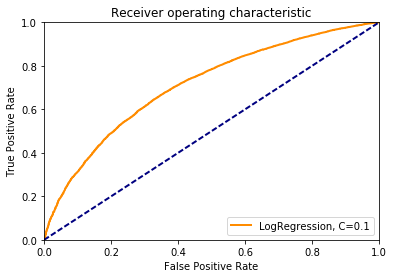

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure()
line_width = 2
fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, color='darkorange', lw=line_width, label='LogRegression, C=0.1')
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Вычислим предсказания для тестового набора
Загружаем данные:

In [56]:
test = pd.read_csv('test.csv', index_col='record_id')

Делаем действия аналогичные проделанным с train набором:

In [57]:
test['is_title_known'] = test['emp_title'].map(lambda x: 0 if x == 'n/a' else 1)
test.drop('emp_title', axis=1, inplace=True)

test['is_delinq_occurs'] = test['mths_since_last_delinq'].map(lambda x: 0 if math.isnan(x) else 1)
max_mths_since_last_delinq = np.nanmax(test.mths_since_last_delinq.values)
test['mths_since_last_delinq'].fillna(max_mths_since_last_delinq, inplace=True)

test.fillna(0, inplace=True)
test.isnull().sum()

loan_amnt                     0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
mths_since_last_delinq        0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
collections_12_mths_ex_med    0
policy_code                   0
application_type              0
acc_now_delinq                0
tot_coll

\- Пропусков нету, как и ожидаем

In [58]:
print test.shape

(66730, 36)


### Подготовим нечисловые столбцы:

In [59]:
encode_with_existing_LabelEncoder(test, 'term', term_le_encoder)
encode_with_existing_LabelEncoder(test, 'grade', grade_le_encoder)
encode_with_existing_LabelEncoder(test, 'sub_grade', sub_grade_le_encoder)

test = encode_with_OneHotEncoder_using_existing_LabelEncoder_and_delete_column(test, 'emp_length', emp_length_le_encoder)
test = encode_with_OneHotEncoder_using_existing_LabelEncoder_and_delete_column(test, 'home_ownership', home_ownership_le_encoder)
test = encode_with_OneHotEncoder_using_existing_LabelEncoder_and_delete_column(test, 'verification_status', verification_status_le_encoder)

encode_with_func(test, 'issue_d', convert_date)
encode_with_existing_LabelEncoder(test, 'pymnt_plan', pymnt_plan_le_encoder)

test = encode_with_OneHotEncoder_using_existing_LabelEncoder_and_delete_column(test, 'purpose', purpose_le_encoder)

test.drop(['zip_code'], axis=1, inplace=True)
encode_with_existing_LabelEncoder(test, 'addr_state', addr_state_le_encoder)
encode_with_func(test, 'earliest_cr_line', convert_date)
encode_with_existing_LabelEncoder(test, 'initial_list_status', initial_list_status_le_encoder)
encode_with_existing_LabelEncoder(test, 'application_type', application_type_le_encoder)

X.dtypes

loan_amnt                              float64
int_rate                               float64
installment                            float64
annual_inc                             float64
dti                                    float64
delinq_2yrs                            float64
inq_last_6mths                         float64
mths_since_last_delinq                 float64
open_acc                               float64
pub_rec                                float64
revol_bal                              float64
revol_util                             float64
total_acc                              float64
collections_12_mths_ex_med             float64
policy_code                            float64
acc_now_delinq                         float64
tot_coll_amt                           float64
tot_cur_bal                            float64
total_rev_hi_lim                       float64
is_title_known                           int64
is_delinq_occurs                         int64
term_le      

In [60]:
print test.shape

(66730, 65)


In [61]:
scaled_test = scaler.transform(test)

In [62]:
clf = LogisticRegression(penalty='l2', C=0.1)
clf.fit(scaledX, Y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [63]:
prediction = clf.predict_proba(scaled_test)[:, 1]

Убедимся, что предсказанные вероятности находятся на отрезке [0,1] и не совпадают между собой (т.е. что модель не получилась константной):

In [64]:
print min(prediction), max(prediction)

0.0 0.999999996487


Преобразуем prediction в DataFrame:

In [65]:
result = pd.DataFrame(np.array(prediction), columns=['prob1'], index=test.index)
print result[result['prob1']>0.5].count()
print result.count()

prob1    711
dtype: int64
prob1    66730
dtype: int64


Немного странно конечно, что из 67К записей только у 0.7К вероятность больше 0.5

Сохраняем результаты:

In [66]:
result.to_csv('result.csv', encoding='utf8')